1.a. CNNs are trained on labled data sets that are often very large. In transfer learning, these learned features can be transferred to a new task, which is especially useful when the new task has a similar feature space, specifically with respect to image types or classifications.  This greatly reduces the amount of effort needed to gather and label data as well as train the model.

2.b See code below

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Adjust the path to the folder containing the dataset if necessary
%cd gdrive/MyDrive/Colab\ Notebooks

/content/gdrive/MyDrive/Colab Notebooks


In [4]:
import os
if not os.path.exists("dataset"):
  !unzip -q dataset_problem_1

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm import tqdm

# Construct dataset and define utility functions

In [6]:
data_dir = 'dataset'

transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
torch.manual_seed(101)
dataset = datasets.ImageFolder(data_dir, transform=transform)
num_classes = len(dataset.classes)

def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    return Subset(dataset, train_idx), Subset(dataset, val_idx)

train, val = train_val_dataset(dataset)

train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True, pin_memory=True)

device = torch.device("cuda:0")

In [7]:
def visualize_predictions(model, num_images=9):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3, 3, images_so_far)
                ax.set_title(f'predicted: {dataset.classes[preds[j]]}')
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.tick_params(axis='both', length=0)
                ax.set_xticklabels('')
                ax.set_yticklabels('')
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                plt.imshow(inp)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
def train_model(model, epochs):
    model.to(device)
    times = []
    train_acc = []
    val_acc = []
    start_time = time.time()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    np.random.seed(101)
    for epoch in range(epochs):
        running_loss = 0
        train_accuracy = 0
        val_accuracy = 0
        for ix, (data, label) in enumerate(train_loader):
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()
            train_accuracy += torch.sum(pred.argmax(dim=1)==label).item() / data.shape[0]

        for ix, (data, label) in enumerate(val_loader):
            data, label = data.to(device), label.to(device)
            pred = model(data)
            loss = criterion(pred, label)
            val_accuracy += torch.sum(pred.argmax(dim=1)==label).item() / data.shape[0]

        train_acc.append(train_accuracy/len(train_loader))
        val_acc.append(val_accuracy/len(val_loader))
        times.append(time.time() - start_time)
        print(f'Epoch: {epoch}, Train Accuracy: {train_acc[-1]}, Validation Accuracy: {val_acc[-1]}, Time: {time.time() - start_time}')
    return times, train_acc, val_acc

# Simple CNN

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(2048, 64),
            nn.ReLU(),
            nn.Linear(64,9)
        )

    def forward(self, xb):
        return self.network(xb)

model_CNN = SimpleCNN(num_classes=num_classes)

In [23]:
# Train the model
num_epochs = 30
times, train_acc, val_acc = train_model(model_CNN, epochs=num_epochs)

Epoch: 0, Train Accuracy: 0.9502840909090909, Validation Accuracy: 0.73828125, Time: 6.0800299644470215
Epoch: 1, Train Accuracy: 0.9801136363636364, Validation Accuracy: 0.75390625, Time: 12.338138103485107
Epoch: 2, Train Accuracy: 0.9886363636363636, Validation Accuracy: 0.63671875, Time: 18.320068359375
Epoch: 3, Train Accuracy: 0.9971590909090909, Validation Accuracy: 0.62890625, Time: 24.545233964920044
Epoch: 4, Train Accuracy: 0.9985795454545454, Validation Accuracy: 0.625, Time: 30.48870348930359
Epoch: 5, Train Accuracy: 0.9971590909090909, Validation Accuracy: 0.63671875, Time: 36.69179439544678
Epoch: 6, Train Accuracy: 0.9985795454545454, Validation Accuracy: 0.7109375, Time: 42.69222617149353
Epoch: 7, Train Accuracy: 0.9644886363636364, Validation Accuracy: 0.7109375, Time: 48.756999015808105
Epoch: 8, Train Accuracy: 0.9715909090909091, Validation Accuracy: 0.734375, Time: 54.90617561340332
Epoch: 9, Train Accuracy: 0.9971590909090909, Validation Accuracy: 0.66015625, T

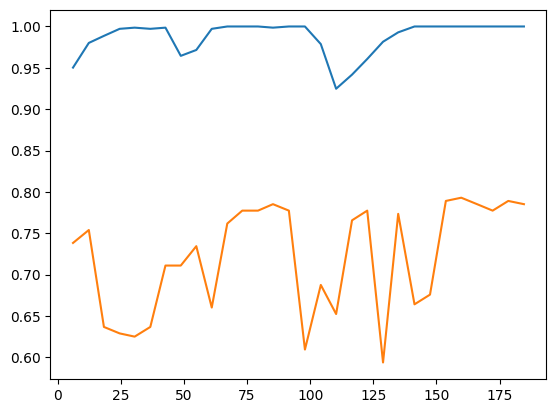

Average time per epoch: 6.15530211130778


In [24]:
plt.plot(times, train_acc)
plt.plot(times, val_acc)
plt.show()
print(f"Average time per epoch: {times[-1]/len(times)}")

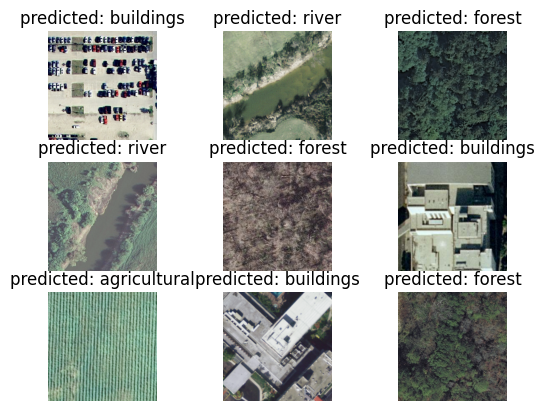

In [12]:
visualize_predictions(model_CNN)

# Untrained ResNet-18

1.c See Code Below

In [13]:
# Load pre-trained ResNet-18 model
model_untrained_resnet = models.resnet18(weights=None)

num_ftrs = model_untrained_resnet.fc.in_features

# TODO Replace the fully connected layer (classifier)
model_untrained_resnet.fc = nn.Linear(num_ftrs, 9)

# Train the model
num_epochs = 30
times, train_acc, val_acc = train_model(model_untrained_resnet, epochs=num_epochs)

Epoch: 0, Train Accuracy: 0.4460227272727273, Validation Accuracy: 0.48828125, Time: 7.550841569900513
Epoch: 1, Train Accuracy: 0.6060606060606061, Validation Accuracy: 0.6015625, Time: 14.872285842895508
Epoch: 2, Train Accuracy: 0.6377840909090909, Validation Accuracy: 0.625, Time: 22.928443431854248
Epoch: 3, Train Accuracy: 0.7547348484848485, Validation Accuracy: 0.640625, Time: 30.07641577720642
Epoch: 4, Train Accuracy: 0.8181818181818182, Validation Accuracy: 0.6640625, Time: 37.312158823013306
Epoch: 5, Train Accuracy: 0.8489583333333333, Validation Accuracy: 0.6953125, Time: 44.74074101448059
Epoch: 6, Train Accuracy: 0.8020833333333333, Validation Accuracy: 0.66796875, Time: 55.74134874343872
Epoch: 7, Train Accuracy: 0.796875, Validation Accuracy: 0.6640625, Time: 66.99769043922424
Epoch: 8, Train Accuracy: 0.8409090909090909, Validation Accuracy: 0.64453125, Time: 74.07656764984131
Epoch: 9, Train Accuracy: 0.8745265151515151, Validation Accuracy: 0.734375, Time: 81.35661

In [14]:
print(num_ftrs)

512


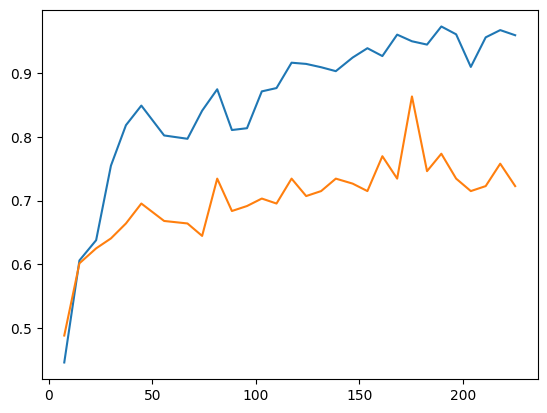

Average time per epoch: 7.504643400510152


In [15]:
plt.plot(times, train_acc)
plt.plot(times, val_acc)
plt.show()
print(f"Average time per epoch: {times[-1]/len(times)}")

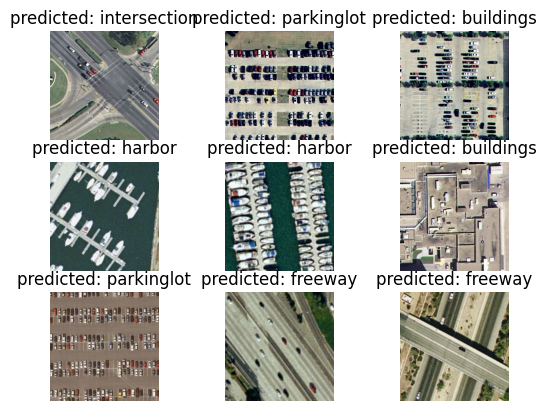

In [16]:
visualize_predictions(model_untrained_resnet)

# Pre-trained ResNet-18

2.d See Code below

In [19]:
# Load pre-trained ResNet-18 model
model_pretrained_resnet = models.resnet18(weights="IMAGENET1K_V1")

# Freeze the pre-trained layers
for param in model_pretrained_resnet.parameters():
    param.requires_grad = False

num_ftrs = model_pretrained_resnet.fc.in_features

# TODO Replace the fully connected layer (classifier)
model_pretrained_resnet.fc = nn.Linear(num_ftrs, 9)

# Train the model
num_epochs = 30
times, train_acc, val_acc = train_model(model_pretrained_resnet, epochs=num_epochs)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


Epoch: 0, Train Accuracy: 0.13068181818181818, Validation Accuracy: 0.1953125, Time: 5.8727192878723145
Epoch: 1, Train Accuracy: 0.3693181818181818, Validation Accuracy: 0.46875, Time: 12.12614631652832
Epoch: 2, Train Accuracy: 0.633996212121212, Validation Accuracy: 0.60546875, Time: 18.069013833999634
Epoch: 3, Train Accuracy: 0.75, Validation Accuracy: 0.6796875, Time: 24.236209392547607
Epoch: 4, Train Accuracy: 0.7902462121212122, Validation Accuracy: 0.72265625, Time: 30.084428787231445
Epoch: 5, Train Accuracy: 0.8319128787878788, Validation Accuracy: 0.77734375, Time: 36.17822623252869
Epoch: 6, Train Accuracy: 0.871685606060606, Validation Accuracy: 0.90625, Time: 42.07975172996521
Epoch: 7, Train Accuracy: 0.8896780303030304, Validation Accuracy: 0.7890625, Time: 48.22874689102173
Epoch: 8, Train Accuracy: 0.909564393939394, Validation Accuracy: 0.79296875, Time: 54.069947957992554
Epoch: 9, Train Accuracy: 0.9133522727272727, Validation Accuracy: 0.80078125, Time: 60.16178

In [20]:
print(num_ftrs)

512


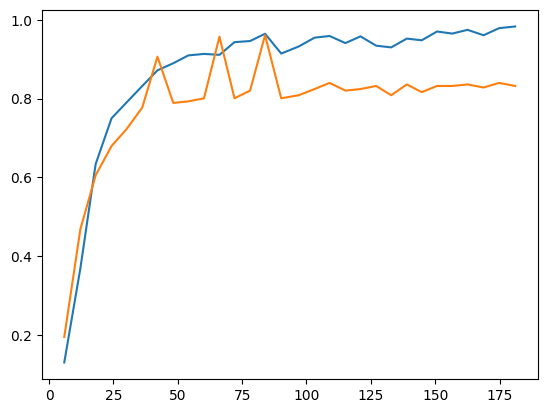

Average time per epoch: 6.036312747001648


In [21]:
plt.plot(times, train_acc)
plt.plot(times, val_acc)
plt.show()
print(f"Average time per epoch: {times[-1]/len(times)}")

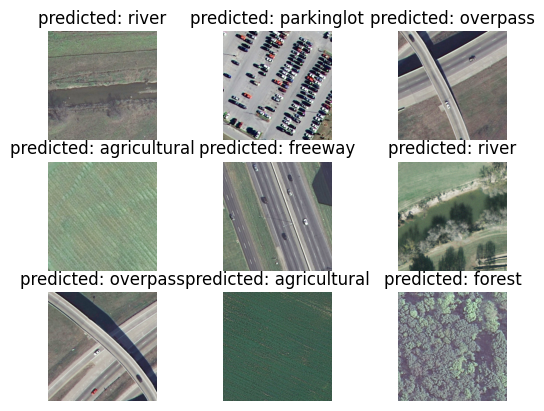

In [22]:
visualize_predictions(model_pretrained_resnet)

2.e.  <br>
Built CNN: Average time per epoch: 6.15530211130778 <br>

Resnet no pretrain: Average time per epoch: 7.504643400510152 <br>

Pretrained Resnet: Average time per epoch: 6.036312747001648 <br>

1. For the average training time the pre-trained Resnet had the best results, and the manually built CNN had then next best training time.<br>

2. The pretrained Resnet provided the best convergence for accuracy although its maximum accurace appears to be lower than that of the untrained Resnet.  Intuitively this makes sense as the model is trained on our specific data set for the untrained Resnet, while the trained resnet is evaluating, thus the differences in training time and accuracy. <br>

3. In our built CNN has around 170,000 trainable parameters, while Resnet-18 har around 11 million.  The pretrained resnet where we are just freezing the last layer would have considerably fewer parameters, somewhere around 9,000.


2.f. <br>
1. You could choose to freeze different layers.  In doing this you could look to finetune which layers provides the most accurate output.  This would take considerable amount of time and likely would be specific to the data set that you are implementing and would not be easily transfered to a different data set.<br>
2.  You could perform feature extraction following the use of the pre trained Resnet.  After extracting the features, these could be leveraged to train a separate classifier that is better tailored for our specific task.  This could result in improved ability to drive interpretability and customization for a specific goal.